---
# Drzewa decyzyjne #
---

## 0. Podłączenie dysku Google'a ##

In [12]:
#from google.colab import drive
#drive.mount('/content/drive/')

/home/feigenbaum/anaconda3/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


KeyError: 'CLOUDSDK_CONFIG'

In [15]:
folder = '/home/feigenbaum/Downloads/' # podaj lokalizację pliku

## 1. Wstęp ##
W bibliotece scikit-learn drzewa decyzyjne implementowane są przez klasę [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). Szczegóły implementacji opisane są [tutaj](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use).

Aby nauczyć taki klasyfikator potrzebujemy tablicę X o rozmiarach [N_przykładów, N_cech] i wektor Y określający przynależność przykładów w X do klas.

Najprostszy przykład:

In [1]:
from sklearn import tree
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

Po dopasowaniu można przewidywać przynależność nowych przykładów:

In [2]:
clf.predict([[2., 2.]])

array([1])

Albo estymować prawdopodobieństwo przynależności do klas:

In [3]:
clf.predict_proba([[2., 2.]])

array([[0., 1.]])

## 2. Klasyfikacja irysów ##

In [6]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf.fit(iris.data, iris.target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Po wytrenowaniu można zilustrować wynik za pomocą narzędzia Graphiz (wymaga to zainstalowania w systemie tego narzędzia), oraz doinstalowania do pythona biblioteki pydot:

In [7]:
from sklearn.externals.six import io
import pydot 
dot_data = io.StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_pdf("iris.pdf")

Można też podejrzeć wyniki w pythonie:

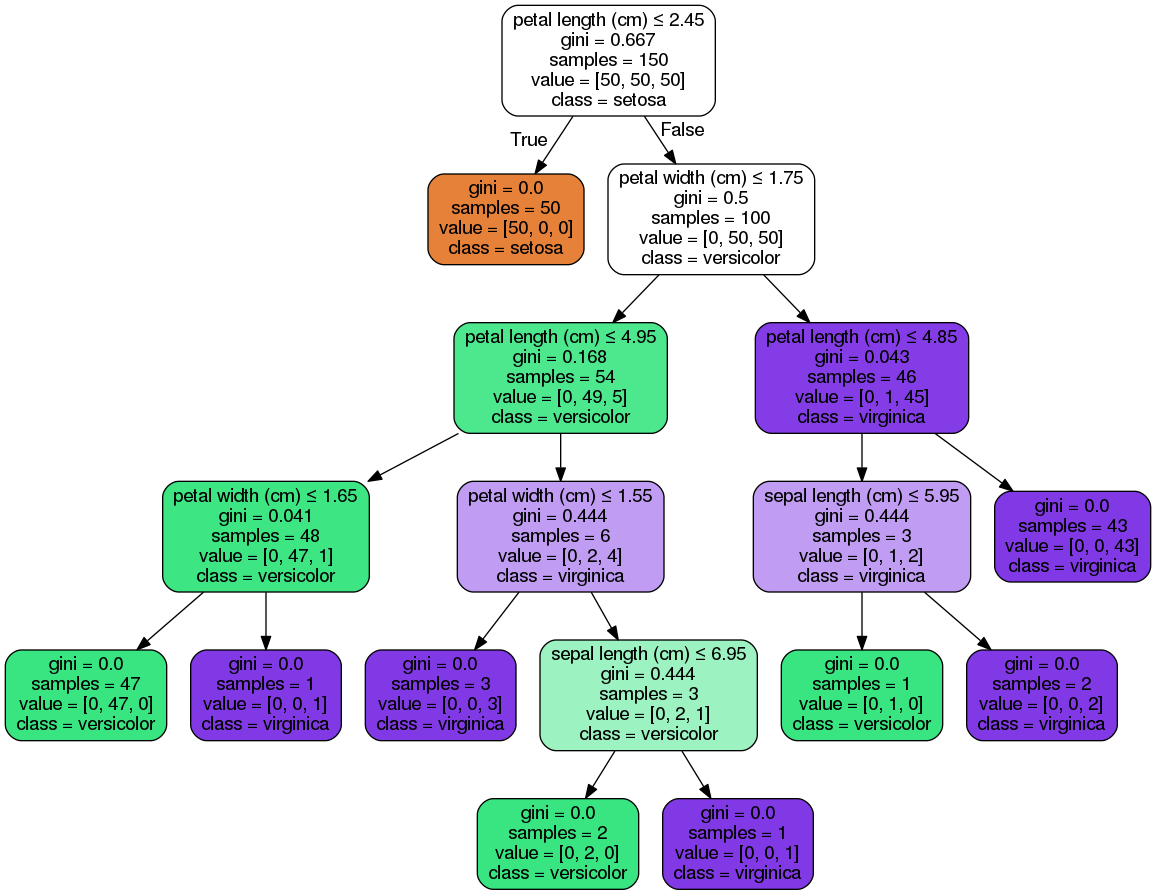

In [8]:
from IPython.display import Image  
dot_data = io.StringIO()  
tree.export_graphviz(clf, out_file=dot_data,    feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

Po dopasowaniu model ten może być zastosowany do przewidywania przynależności przykładów do klas:

In [9]:
clf.predict(iris.data[:1, :])

array([0])

lub estymowania prawdopodobieństwa przynależności do klas:

In [10]:
clf.predict_proba(iris.data[:1, :])

array([[1., 0., 0.]])

## 2. Klasyfikacja ręcznie pisanych cyfr (MNIST) ##

Teraz spróbujmy klasyfikacji ręcznie pisanych cyfr. Pierwszą rzeczą z jaką musimy sobie poradzić to reprezentacja cyfr tak aby dało się z nich zbudować ciąg uczący.

W surowej postaci dostalibyśmy obrazek, tzn. macierz pikseli  n \times m. W naszym przypadku pierwotne obrazki były skanowane i rozdzielane na poszczególne cyfry przez otaczanie każdej cyfry pudełkiem centrowanym na środku masy piksli, a nastepnie znormalizowane do rozmiarów 20 \times 20 .

Dane z których będziemy korzystać stanowią obrazek przetworzony do formatu jednowymiarowego przez ułożenie kolejnych wierszy. Dane te pochodzą z bazy danych ręcznie pisanych cyfr [MNIST]((http://yann.lecun.com/exdb/mnist/), a ich wersja matlabowa jest dostępna w naszym folderze 'dane' w pliku o nazwie mnist.mat.

dane zawierają 5000 cyfr po 400 pixli


/home/feigenbaum/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


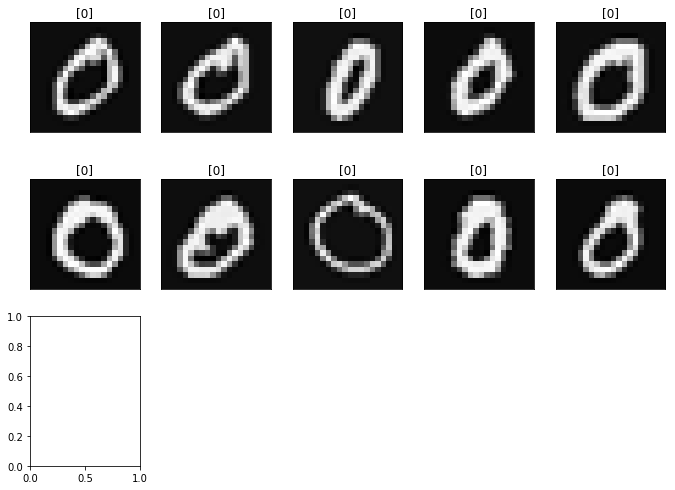

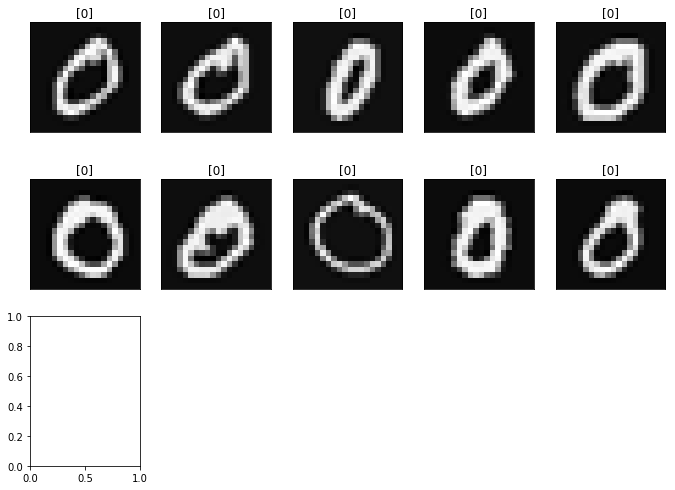

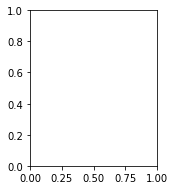

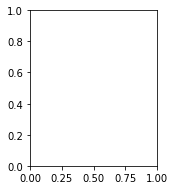

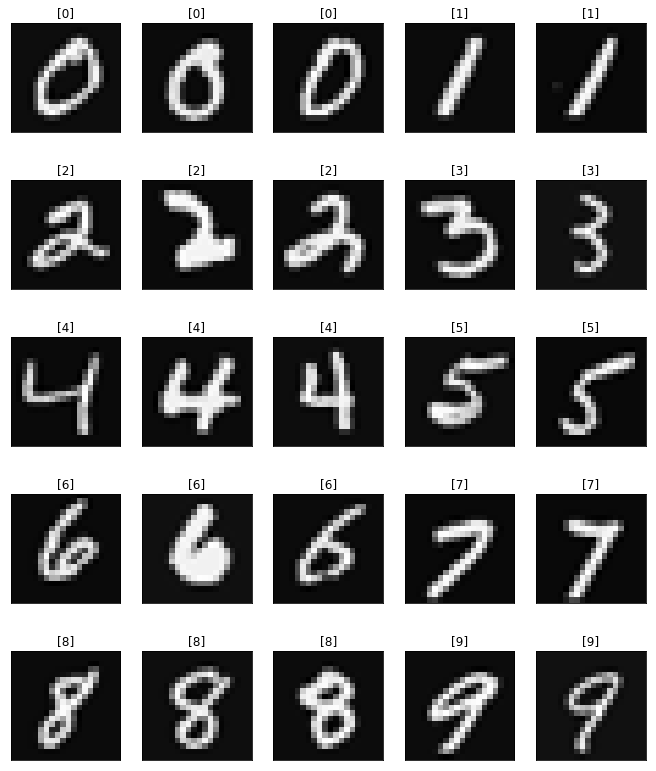

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

###############################################################################
# podglądanie obrazków cyfr
# funkcja pomocnicza 
#
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.05)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)).T, cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
 
###############################################################################
# wczytywanie danych
dane = loadmat(folder + 'mnist.mat')
#przepisanie danych do osobnych tablic:
X = dane['X']
y = dane['y']
for i in range(X.shape[0]):
    X[i,:] = X[i,:]/np.std(X[i,:])
y[np.where(y==10)]=0 # przekodoeanie cyfry 0 tak, żeby w wektorze y też odpowiadąło jej 0 (w oryginalnym zbiorze danych było 10)
 
# wysokość i szerokość obrazka z cyfrą 
h = 20
w = 20
 
###############################################################################
# Wypisz dane o zbiorze cyfr 
print("dane zawierają %d cyfr po %d pixli" % (X.shape[0], X.shape[1]))
 
# Pokaż kilka przykładowych cyfr:
plot_gallery(X[0:5000:200,:], y[0:5000:200], h, w, n_row=5, n_col=5)
plt.show()

In [70]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split

###############################################################################
# Podziel zbiór na dane treningowe i testowe za pomocą funkcji opisanej tu w proporcji 5:1 :
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html
# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  
###############################################################################
#Ad 1

#MFmin=1
#MFmax=250
#DEPTHmin=1
#DEPTHmax=10000

#zakresMF = np.logspace(np.log2(MFmin),np.log2(MFmax),32, base=2)
#zakresDEPTH = np.logspace(np.log2(DEPTHmin),np.log2(DEPTHmax),32, base=2)

#fscoremax=0
#MFbest=0
#modelBest=None
#DEPTHbest=0

#for MAX_FEAT in zakresMF:
#    for DEPTH in zakresDEPTH:
#        MAX_FEAT=int(MAX_FEAT)
#        DEPTH=int(DEPTH)
#        
#        clf  = tree.DecisionTreeClassifier(max_depth=DEPTH, max_features=MAX_FEAT)
#        clf = clf.fit(X_train, y_train)
#        y_pred = clf.predict(X_test)# predykcja na danych testowych
#        fscore =f1_score(y_test, y_pred, average='weighted')
#       print('f1score = ',fscore)
#        print('DEPTH = ',DEPTH,', MAX_FEATURES = ',MAX_FEAT)
#        print('========================================')
#        
#        if fscore > fscoremax:
#            fscoremax= fscore
#            MFbest=MAX_FEAT
#            DEPTHbest=DEPTH
            #modelbest=model

    # uzupełnij miary klasyfikacji
#    print("wynik F1 (ważony): optymalny")
#    print(fscoremax)
#    print('DEPTH optimal = ',DEPTHbest,', MAX_FEATURES optimal = ',MFbest)
     
#print("dokładność: ")
#print(accuracy_score(y_test,y_pred))
#print("confusion matrix:")
#print(confusion_matrix(y_test,y_pred))
#print("raport klasyfikacji:")
#print(classification_report(y_test,y_pred))
##################################################################################################
#Ad 2

DEPTH=10
MAX_FEATURES=175

for n in range(1,100):
    ts=n/100
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts)
    clf  = tree.DecisionTreeClassifier(max_depth=DEPTH, max_features=MAX_FEAT)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)# predykcja na danych testowych
    print("podział: ",ts,"l. przykł. w zbiorze ucz.: ",np.size(y_train),"dokładność: ",accuracy_score(y_test,y_pred))

podział:  0.01 l. przykł. w zbiorze ucz.:  4950 dokładność:  0.66
podział:  0.02 l. przykł. w zbiorze ucz.:  4900 dokładność:  0.79
podział:  0.03 l. przykł. w zbiorze ucz.:  4850 dokładność:  0.8066666666666666
podział:  0.04 l. przykł. w zbiorze ucz.:  4800 dokładność:  0.74
podział:  0.05 l. przykł. w zbiorze ucz.:  4750 dokładność:  0.868
podział:  0.06 l. przykł. w zbiorze ucz.:  4700 dokładność:  0.8033333333333333
podział:  0.07 l. przykł. w zbiorze ucz.:  4649 dokładność:  0.7891737891737892
podział:  0.08 l. przykł. w zbiorze ucz.:  4600 dokładność:  0.78
podział:  0.09 l. przykł. w zbiorze ucz.:  4550 dokładność:  0.7955555555555556
podział:  0.1 l. przykł. w zbiorze ucz.:  4500 dokładność:  0.778
podział:  0.11 l. przykł. w zbiorze ucz.:  4450 dokładność:  0.78
podział:  0.12 l. przykł. w zbiorze ucz.:  4400 dokładność:  0.775
podział:  0.13 l. przykł. w zbiorze ucz.:  4350 dokładność:  0.7907692307692308
podział:  0.14 l. przykł. w zbiorze ucz.:  4299 dokładność:  0.7389443

##Zadanie 1.##
Bazując na powyższym kodzie, zbadaj zależność miary F1 od parametru:
- głębokości drzewa,
- liczby cech wykorzystanych w klasyfikacji.

Ad 1
Parametr F1 polepsza się wraz z głebokością drzewa a potem ulega stabilizacji (dość szybko). Parametr F1 polepsza się wraz ze wzrostem MAX_FEAT a potem ulega stablizacji przy czym im większa głębokość drzewa tym szybciej zachodzi stabilizacja.

Dla optymalnych parametrów DEPTH i MAX_FEAT zbadaj zależność dokładności (accuracy) od liczby przykładów w zbiorze uczącym.

Ad 2
Znalezione wartości optymalne to DEPTH=10, MAX_FEAT=175.
Dokładność generalnie rośnie wraz ze wzrostem liczby przykładów w zbiorze uczącym (coraz wolniej) ale gdy zbiór uczący jest za duży (tutaj: > 98% całości) to dokładnośc maleje.


## Zadanie 2. ##
Na podstawie [tutorialu](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py), proszę przeanalizować strukturę drzewa wyhodowanego do rozpoznawania cyfr.


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

DEPTH=10
MAX_FEATURES=175 
    
estimator = tree.DecisionTreeClassifier(max_depth=DEPTH, max_features=MAX_FEAT)
estimator.fit(X_train, y_train)

# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = estimator.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.
# For a group of samples, we have the following common node.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

plt.show()
sample_ids = [0,999]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))
print()


The binary tree structure has 491 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 209] <= 3.7588634490966797 else to node 434.
	node=1 test node: go to node 2 if X[:, 230] <= 0.00854249601252377 else to node 117.
		node=2 test node: go to node 3 if X[:, 111] <= 0.5982732176780701 else to node 66.
			node=3 test node: go to node 4 if X[:, 67] <= 0.0020654494292102754 else to node 55.
				node=4 test node: go to node 5 if X[:, 153] <= 0.9091918170452118 else to node 26.
					node=5 test node: go to node 6 if X[:, 345] <= 0.314101941883564 else to node 21.
						node=6 test node: go to node 7 if X[:, 71] <= 1.1400844156742096 else to node 20.
							node=7 test node: go to node 8 if X[:, 147] <= 1.035701870918274 else to node 13.
								node=8 test node: go to node 9 if X[:, 188] <= 3.93211030960083 else to node 12.
									node=9 test node: go to node 10 if X[:, 154] <= -0.10083218291401863 else to node 11.
										node=10 leaf node.
										node=

Dla DEPTH=10, MAX_FEATURES=175, oraz podziału 0.2 dostajemy drzewo o około 550 wierzchołkach.
Drzewo ma 1000 liści. Typowo liście mają < 1% wspólnych wierzchołków.